<a href="https://colab.research.google.com/github/Ellen-Gu/jupyter-colab/blob/main/Exponential_weight_moving_average_and_period_settings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Some thoughts about EWM.**

Recently I read a book which talking about exponetial weight moving average. After some thinking of the underlying formula, I realiazed that math series accumulation can be helpful in finding the information loss tolerating threshold under different selection of $\alpha$.  

The weight formula for ith period ago is defined as: $\alpha(1-\alpha)^i$, where alpha is the weight giving to most recent period, and i denote the period number which is i-th period ago from the most recent period.

For this weight formula, we know in math that $\sum_{i=0}^\infty \alpha(1-\alpha)^i=1$. This means when we take in all period of historical data we have weight added up to 1, or, in the other word, we have zero information loss. However, in practice we can only maintain limited period of data, say, 4 years (48 months) of data. the period can be time unit such as day, month, quarter, or even year. Based on this thinking, openai and I collaborate together to make the following function, with plot to add some vivid illustration to help to find how much period we need under the condition of accumulated information loss.

In the following plot, accoumated information loss is set to be 1%. that is, $\sum_{t=i+1}^\infty \alpha(1-\alpha)^t=1\%$. Hence the question turns to be: under 1% information loss constraint, and for each of the weight choice given to most recent period, how many periods we have to keep in our data for further analysis.

The function which generating the plot will have a pandas data frame returned to conatin threshold, $\alpha$, and $i$, where i is the minimal necessary period to keep in data. From the results we can see that if under mild $\alpha$, the minimal periods needed to retain 99% information is 20. If the period unit is month, then this indicated that one and a half years of data are needed. When under some small $\alpha$ (more emphsis on historical data), say, $\alpha=0.1$, then we may need around 4 years of data to have infomration retaining rate above 99%, if the period unit is month.

Since all weights are not added up to 1, shall we normalize all weights? Openai says that will make the ewm no longer the traditional one. That seems not verypersuvidable. My understanding is that for giving threshold,$alpha$ and $i$, the $\sum_{t=i+1}^\infty \alpha(1-\alpha)^t$ is usually set to be ignorable, and it is a constant across all data points. Hence whether normalize it or not does not influence its line shape, but absolute values. In Bayes analysis, the denominator is usually a constant, hence no much need to really  calculate it out, even we may get some improper distitubtion.

Based on this, we may think about other functions can be used when giving weights to data. As long as the series is positive and "integratable" they may be used as weights. So any distribution density functions, and many number series can be weights. Among them the ones which have practical meanings, such as the ewm, could be more reasonable in describing or modelling real-world problems.

I am very happy to have openai along with me in my thinkings process. Long time ago I wish to have such an accompany collaborator in my journey. However, when talking about math questions, it often try to "think" striaghtly or in a forward way. Say, when asked to get $\sum_{t=i+1}^\infty \alpha(1-\alpha)^t$, and it knows that $\sum_{i=0}^\infty \alpha(1-\alpha)^i=1$, openai still trys to calculate the summation of infinite items hence has difficulties to reach accurate answer. Aside from that, openai is really a super strong collaborator.



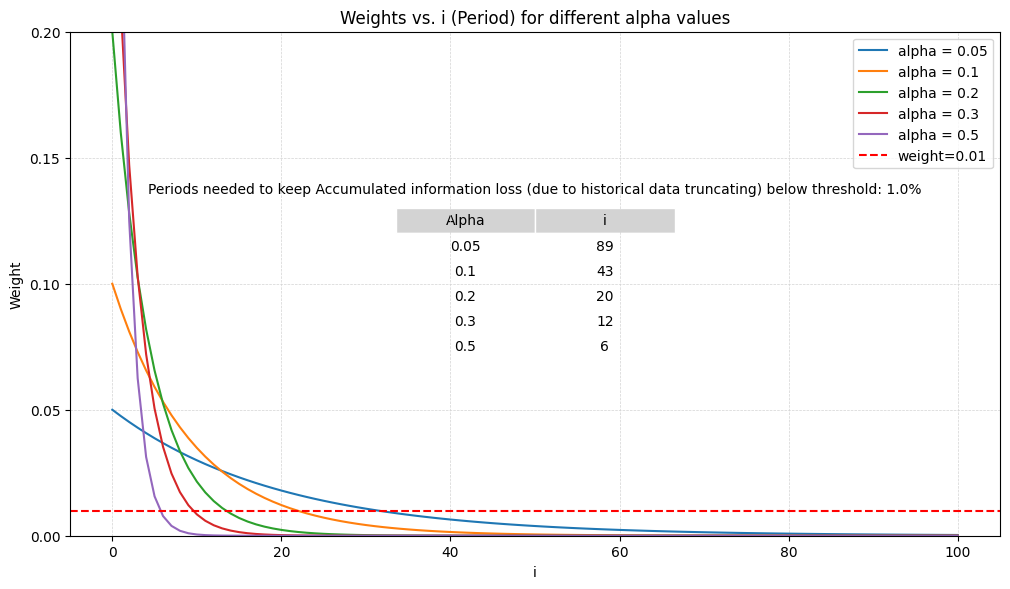

   threshold  alpha   i
0       0.01   0.05  89
1       0.01   0.10  43
2       0.01   0.20  20
3       0.01   0.30  12
4       0.01   0.50   6


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_weights(threshold=0.01, alphas=[0.05, 0.1, 0.2, 0.3, 0.5]):
    i_values = np.arange(0, 101)
    data = {'alpha': [], 'i': []}

    plt.figure(figsize=(12, 8))

    for alpha in alphas:
        weights = alpha * (1 - alpha) ** i_values
        cumulative_weights = np.cumsum(weights)
        distance_from_one_minus_threshold = np.abs(cumulative_weights - (1 - threshold))

        i_nearest_threshold = np.argmin(distance_from_one_minus_threshold)

        data['alpha'].append(alpha)
        data['i'].append(i_nearest_threshold)

        plt.plot(i_values, weights, label=f'alpha = {alpha}')

    plt.axhline(y=threshold, color='r', linestyle='--', label='weight=0.01')
    plt.title("Weights vs. i (Period) for different alpha values")
    plt.xlabel("i")
    plt.ylabel("Weight")
    plt.legend(loc='upper right')
    plt.ylim(0, 0.2)
    plt.yticks(np.arange(0, 0.21, 0.05))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    # Add the table
    table_data = [['Alpha', 'i']]
    for alpha, i in zip(alphas, data['i']):
        table_data.append([alpha, i])
    table = plt.table(cellText=table_data, cellLoc='center', loc='center',
                      bbox=[0.35, 0.35, 0.3, 0.3])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.4, 1.4)
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('white')
        if key[0] == 0:
            cell.set_facecolor('lightgray')
        else:
            cell.set_facecolor('white')

    # Table title
    table_title = f"Periods needed to keep Accumulated information loss (due to historical data truncating) below threshold: {threshold*100}%"
    plt.annotate(table_title, (0.5, 0.68), xycoords='axes fraction', ha='center', fontsize=10, color='black')

    plt.subplots_adjust(bottom=0.25)
    plt.show()

    data["threshold"]=threshold
    data=pd.DataFrame(data).T.loc[["threshold","alpha","i"]].T
    data[["i"]]=np.int8(data[["i"]])

    return data

df = plot_weights()
print(df)
